In [ ]:
from google.colab import files
uploaded = files.upload()

Saving _train_sem09 (1).csv to _train_sem09 (1).csv


# Прогнозирование биологического ответа.

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).
Данные представлены в формате CSV.  Каждая строка представляет молекулу.

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.                                     
**Предварительная обработка не требуется, данные уже закодированы и нормализованы.**

В качестве метрики будем использовать F1-score.
Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [ ]:
import pandas as pd
data = pd.read_csv('_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%capture
!pip install seaborn
!pip install hyperopt
!pip install optuna
!pip install ipywidgets

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


In [ ]:
import numpy as np
random_seed = 42

In [ ]:
!pip freeze > requirements.txt

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


0.18462434478741985


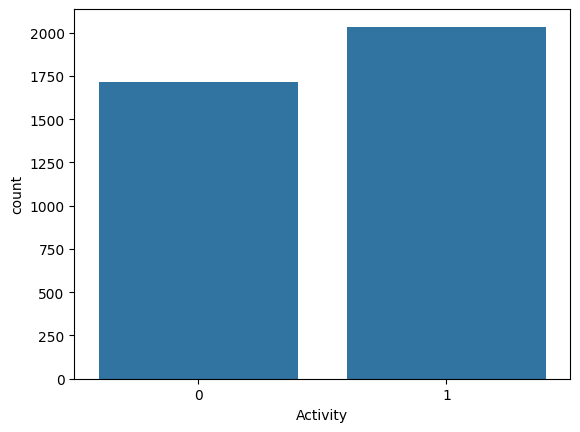

In [ ]:
import seaborn as sns

# Проверка на сбалансированность таргета
sns.countplot(data=data, x='Activity');
print(data['Activity'].value_counts()[1] / data['Activity'].value_counts()[0] - 1)


In [ ]:
data['Activity'].value_counts()

,count
Activity,
1,2034
0,1717


In [ ]:
# Разделение выборки на обучающюю и тестовую
from sklearn.model_selection import train_test_split
random_seed = 42


X = data.drop(['Activity'], axis=1)
y = data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_seed, test_size=0.2)

X_train.shape, X_test.shape

((3000, 1776), (751, 1776))

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
# Создаем объект класса логистическая регрессия
#lr = LogisticRegression(random_state=42)
lr = LogisticRegression(random_state=42, solver='saga', max_iter=1000)

# Обучаем модель
lr.fit(X_train, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(lr.score(X_test, y_test)))
y_test_pred = lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
CPU times: user 1min 4s, sys: 65.4 ms, total: 1min 4s
Wall time: 1min 6s


# RandomForestClassifier
- Построение модели случайного леса
- Настройка гиперпараметров - GridSearchCV
- Настройка гиперпараметров - RandomizedSearchCV   

In [ ]:
%%time
model = RandomForestClassifier()
model.fit(X_train, y_train)

# прогноз модели
y_pred = model.predict(X_test)

# показатели оценки эффективности модели
print(classification_report(y_pred, y_test))



              precision    recall  f1-score   support

           0       0.74      0.77      0.75       329
           1       0.82      0.79      0.80       422

    accuracy                           0.78       751
   macro avg       0.78      0.78      0.78       751
weighted avg       0.78      0.78      0.78       751

CPU times: user 2.17 s, sys: 37.7 ms, total: 2.21 s
Wall time: 2.21 s


In [ ]:
param_grid = {
	'n_estimators': [25, 50, 100, 150],
	'max_features': ['sqrt', 'log2', None],
	'max_depth': [3, 6, 9],
	'max_leaf_nodes': [3, 6, 9],
}


In [ ]:
%%time
# Параметры, полученные с помощью GridSearchCV

grid_search = GridSearchCV(RandomForestClassifier(),
						param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)


RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=150)
CPU times: user 32min 56s, sys: 6.09 s, total: 33min 2s
Wall time: 33min 9s


In [ ]:
%%time

#Теперь обновим параметры модели теми, которые получены с помощью GridSearchCV
model_grid = RandomForestClassifier(max_depth=9,
									max_features=None,
									max_leaf_nodes=9,
									n_estimators=150)
model_grid.fit(X_train, y_train)
y_pred_grid = model.predict(X_test)
print(classification_report(y_pred_grid, y_test))


              precision    recall  f1-score   support

           0       0.74      0.77      0.75       329
           1       0.82      0.79      0.80       422

    accuracy                           0.78       751
   macro avg       0.78      0.78      0.78       751
weighted avg       0.78      0.78      0.78       751

CPU times: user 33.3 s, sys: 53.7 ms, total: 33.3 s
Wall time: 36.1 s


In [ ]:
%%time
# Параметры, полученные с помощью RandomizedSearchCV

random_search = RandomizedSearchCV(RandomForestClassifier(),
								param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)


RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=150)
CPU times: user 3min 41s, sys: 621 ms, total: 3min 41s
Wall time: 3min 42s


In [ ]:
%%time
# Теперь обновим параметры модели теми, которые получены с помощью RandomizedSearchCV.

model_random = RandomForestClassifier(max_depth=6,
									max_features=None,
									max_leaf_nodes=9,
									n_estimators=150)
model_random.fit(X_train, y_train)
y_pred_rand = model.predict(X_test)
print(classification_report(y_pred_rand, y_test))


              precision    recall  f1-score   support

           0       0.74      0.77      0.75       329
           1       0.82      0.79      0.80       422

    accuracy                           0.78       751
   macro avg       0.78      0.78      0.78       751
weighted avg       0.78      0.78      0.78       751

CPU times: user 32.2 s, sys: 44.6 ms, total: 32.3 s
Wall time: 34.5 s


In [ ]:
%%time
# испытание с n_estimator=50 и его влияние на модель
model_random = RandomForestClassifier(max_depth=9,
									max_features=None,
									max_leaf_nodes=9,
									n_estimators=50)
model_random.fit(X_train, y_train)
y_pred_rand = model.predict(X_test)
print(classification_report(y_pred_rand, y_test))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       329
           1       0.82      0.79      0.80       422

    accuracy                           0.78       751
   macro avg       0.78      0.78      0.78       751
weighted avg       0.78      0.78      0.78       751

CPU times: user 10.6 s, sys: 27.9 ms, total: 10.7 s
Wall time: 10.7 s


# LogisticRegression

- Построение модели логистической регрессии
- Настройка гиперпараметров - GridSearchCV
- Настройка гиперпараметров - RandomizedSearchCV

In [ ]:
%%time

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np


random_seed = 42
# Генерация данных
X = data.drop(['Activity'], axis=1)
y = data['Activity']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение параметров для GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear поддерживает l1 и l2
}

# Инициализация логистической регрессии
model_lr = LogisticRegression(max_iter=1000)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=model_lr, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

# Использование best_estimator_ для предсказаний
best_model = grid_search.best_estimator_
print(best_model)

# фрагмент кода выполнит поиск наилучших параметров
# и вычислит конечный F1-score на тестовом наборе (по условиям задачи)

# Предсказания и оценка
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("F1-score на тестовом наборе:", f1)


LogisticRegression(C=0.3593813663804626, max_iter=1000, penalty='l1',
                   solver='liblinear')
F1-score на тестовом наборе: 0.7955801104972375
CPU times: user 6.09 s, sys: 1.25 s, total: 7.34 s
Wall time: 8min 43s


In [ ]:
%%time

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from scipy.stats import uniform

random_seed = 42

X = data.drop(['Activity'], axis=1)
y = data['Activity']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение параметров для RandomizedSearchCV
param_distributions = {
    'C': uniform(loc=0.001, scale=1000),  # Генерация значений C в диапазоне (0.001, 1000)
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear поддерживает l1 и l2
}

# Инициализация логистической регрессии
model_lr = LogisticRegression()

# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model_lr,
                                   param_distributions=param_distributions,
                                   n_iter=50,  # Количество случайных выборок
                                   scoring='f1',
                                   n_jobs=-1,
                                   cv=5,
                                   random_state=42)

# Обучение
random_search.fit(X_train, y_train)

# Использование best_estimator_ для предсказаний
best_model = random_search.best_estimator_

# Вывод лучшей модели
print("Лучшая модель:", best_model)

# Предсказания и оценка
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)

# Вывод F1-score на тестовом наборе
print("F1-score на тестовом наборе:", f1)


Лучшая модель: LogisticRegression(C=0.7797658410143283, solver='liblinear')
F1-score на тестовом наборе: 0.7927501970055162
CPU times: user 14.1 s, sys: 2.47 s, total: 16.6 s
Wall time: 22min 48s


# Hyperopt

In [ ]:


from hyperopt import hp
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK  # Import all needed components from hyperopt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


# Определение функции для оптимизации
def objective(params):
    model_lr = LogisticRegression(
        C=params['C'],
        penalty=params['penalty'],
        solver='liblinear'
    )
    model_lr.fit(X_train, y_train)
    f1 = f1_score(y_test, model_lr.predict(X_test))
    return {'loss': -f1, 'status': STATUS_OK}

# Определение пространства поиска
space = {
    'C': hp.loguniform('C', np.log(1e-4), np.log(1e4)),
    'penalty': hp.choice('penalty', ['l1', 'l2'])
}

# Запуск Hyperopt
trials = Trials()
best_hyperopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Лучшие параметры (Hyperopt):", best_hyperopt)


  8%|▊         | 4/50 [01:04<18:42, 24.40s/trial, best loss: -0.7924528301886793]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



100%|██████████| 50/50 [04:38<00:00,  5.57s/trial, best loss: -0.7990654205607477]
Лучшие параметры (Hyperopt): {'C': 0.12575576334438587, 'penalty': 0}


### Обновить модель

- обновим параметры модели теми, которые получены с помощью Hyperopt

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


penalty_hyperopt = 'l1' if best_hyperopt['penalty'] == 0 else 'l2'
C_hyperopt = best_hyperopt['C']

#  Logistic Regression model с best parameters от Hyperopt
best_model_hyperopt = LogisticRegression(C=C_hyperopt, penalty=penalty_hyperopt, solver='liblinear', random_state=42)

# обучим model on the training data
best_model_hyperopt.fit(X_train, y_train)

# Прогноз на  test set
y_pred_hyperopt = best_model_hyperopt.predict(X_test)

# подсчет F1-score на test set
f1_score_hyperopt = f1_score(y_test, y_pred_hyperopt)
print("F1-score on the test set with optimized parameters (Hyperopt):", f1_score_hyperopt)


F1-score on the test set with optimized parameters (Hyperopt): 0.7990654205607477
CPU times: user 312 ms, sys: 25.1 ms, total: 337 ms
Wall time: 329 ms


# Optuna

In [ ]:
%%time

import optuna
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Определение функции для оптимизации
def optuna_objective(trial):
    model_lr = LogisticRegression(
        C=trial.suggest_loguniform('C', 1e-4, 1e4),
        penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
        solver='liblinear'
    )
    model_lr.fit(X_train, y_train)
    f1 = f1_score(y_test, model_lr.predict(X_test))
    return f1

# Создание объекта исследования
study = optuna.create_study(direction='maximize')
study.optimize(optuna_objective, n_trials=50)

print("Лучшие параметры (Optuna):", study.best_params)
print("Лучший F1-score (Optuna):", study.best_value)


[I 2024-10-26 10:55:44,108] A new study created in memory with name: no-name-f7c7e840-4cb9-4208-9288-8fb92cfe7404
<timed exec>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-10-26 10:55:44,411] Trial 0 finished with value: 0.7642276422764228 and parameters: {'C': 0.0059330451271139345, 'penalty': 'l1'}. Best is trial 0 with value: 0.7642276422764228.
<timed exec>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-10-26 10:55:45,612] Trial 1 finished with value: 0.7760252365930599 and parameters: {'C': 6.178884426551312, 'penalty': 'l2'}. Best is trial 1 with value: 0.7760252365930599.
<timed exec>:11: FutureWarning: suggest_loguniform has been deprecated i

Лучшие параметры (Optuna): {'C': 0.5779372765152537, 'penalty': 'l1'}
Лучший F1-score (Optuna): 0.7984313725490196
CPU times: user 4min 3s, sys: 5.09 s, total: 4min 8s
Wall time: 4min 12s


### Обновить модель

- обновим параметры модели теми, которые получены с помощью Optuna

In [ ]:
%%time

from sklearn.linear_model import LogisticRegression

# используем best parameters найденная  by Optuna
best_params_optuna = {'C': 0.5779372765152537, 'penalty': 'l1'}
best_model_optuna = LogisticRegression(**best_params_optuna, solver='liblinear', random_state=42)

# обучим модель
best_model_optuna.fit(X_train, y_train)

# Evaluate on the test set
y_pred_optuna = best_model_optuna.predict(X_test)
f1_score_optuna = f1_score(y_test, y_pred_optuna)

print("F1-score on the test set with optimized parameters (Optuna):", f1_score_optuna)


F1-score on the test set with optimized parameters (Optuna): 0.7962382445141066
CPU times: user 1.56 s, sys: 43.2 ms, total: 1.6 s
Wall time: 1.65 s


##### Лучшие параметры, лучший F1-score и наилучшая модель, найденная в процессе подбора гиперпараметров - модель к  которой были применены методы Optuna и Hyperopt